In [5]:

"""
Author: Valentina Matos (Johns Hopkins - Wirtz/Kiemen Lab)
Date: June 22, 2024
"""
import os
import numpy as np
import warnings
from save_model_metadata import save_model_metadata
from load_annotation_data import load_annotation_data
from train_segmentation_model import train_segmentation_model
from create_training_tiles import create_training_tiles
from test_segmentation_model import test_segmentation_model
from classify_images import classify_images
import sys
from PySide6 import QtWidgets
from CODAGUI_fend import MainWindow
warnings.filterwarnings("ignore")

In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
# Execute the GUI
app = QtWidgets.QApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)

window = MainWindow()
window.show()
app.exec()


Form filled with: 
Training path: //10.99.68.52/Kiemendata/Valentina Matos/Dashboard Project/Test
Testing path: //10.99.68.52/Kiemendata/Valentina Matos/Dashboard Project/Test/testing images
Model name: 08_14_2024
Resolution: 5x
Loaded XML file: //10.99.68.52/Kiemendata/Valentina Matos/Dashboard Project/Test\SG_013_0061.xml
      Layer Name           Color Whitespace Settings
0         islets     (0, 255, 0)                None
1    normal duct   (255, 255, 0)                None
2   blood vessel     (255, 0, 0)                None
3            fat   (0, 255, 255)                None
4          acini   (255, 0, 255)                None
5            ecm  (255, 128, 64)                None
6     background     (0, 0, 255)                None
7          panin   (255, 0, 128)                None
8          noise  (64, 128, 128)                None
9          nerve   (128, 0, 255)                None
10        immune     (0, 255, 0)                None
11      HG panin   (255, 255, 0)      

0

In [16]:
#_______________Variable parametrization from GUI_______________

#Paths
pth = window.ui.trianing_LE.text()
pthtest = window.ui.testing_LE.text()
model_name = window.ui.model_name.text()
resolution = window.ui.resolution_CB.currentText()
pthim = os.path.join(pth, f'{resolution}')
pthtestim = os.path.join(pthtest, f'{resolution}')
pthDL = os.path.join(pth, model_name)

#Tif resolution
resolution_to_umpix = {"10x": 1, "5x": 2, "16x": 4}
umpix = resolution_to_umpix.get(resolution, 2)  # Default to 2 if resolution not found

# Get the dataframe with annotation information
combined_df = window.combined_df
classNames = combined_df['Combined names'].tolist()
colormap = combined_df['Combined colors'].tolist()

#Training tile size
tile_size = window.tile_size
#Number of training tiles
ntrain = window.ntrain
nvalidate = window.nval
#Number of validations tiles
nval = window.nval
#Number of TA images to evaluate (coming sooon)
# TA = window.TA

#Create WS
df = window.df
layers_to_delete = df.index[~df['Delete layer']].tolist()
layers_to_delete = [i+1 for i in layers_to_delete] #get row index starting from 1
nesting_list = df['Nesting'].tolist()
nesting_list.reverse()
WS = [df['Whitespace Settings'].tolist(),
      [window.add_ws_to, window.add_nonws_to],
      df['Combined layers'].tolist(),
      nesting_list,
      layers_to_delete
      ]


numclass = max(WS[2])
nblack = numclass + 1;nwhite = WS[1][0]

colormap = np.array(colormap)

#Final Parameters
print('Classnames: ', classNames)
print('Colormap: ', colormap)
print(WS)

Classnames:  ['islets', 'normal duct', 'blood vessel', 'fat', 'acini', 'ecm', 'whitespace', 'panincombo', 'nerve', 'immune', 'PDAC']
Colormap:  [[121 248 252]
 [  0   0 255]
 [ 80 237  80]
 [255 255   0]
 [149  35 184]
 [255 194 245]
 [255 255 255]
 [255   0   0]
 [ 73 120 111]
 [  0   0   0]
 [240 159  10]]
[[2, 0, 0, 1, 0, 0, 2, 0, 2, 2, 2, 0, 0], [7, 6], [1, 2, 3, 4, 5, 6, 7, 8, 7, 9, 10, 8, 11], [6, 5, 4, 11, 1, 2, 3, 8, 10, 12, 13, 7, 9], []]


In [3]:


# Location of tif/png images corresponding to annotated files
pthim = os.path.join(pth, '5x')

# Location of annotations for model testing
pthtest = os.path.join(pth, 'testing images')

# Location of tif/png images corresponding to testing annotated files
pthtestim = os.path.join(pthtest, '5x')

model_name = '06_26_2024_raw_mattiles'

classNames = ['islet', 'duct', 'blood vessel', 'fat','acini','ecm','whitespace','PanIN', 'nerves','immune', 'PDAC']

umpix = 2 # um/pixel of images used  1=10x, 2=5x, 4=16x

# Define actions to take per annotation class
WS = [[2, 0, 0, 1, 0, 0, 2, 0, 2, 2, 2, 0, 0], [7, 6], 
      [1, 2, 3, 4, 5, 6, 7, 8, 7, 9, 10, 8, 11], 
      [6, 5, 4, 11, 1, 2, 3, 8, 10, 12, 13, 7, 9], []]


colormap = [
    [121, 248, 252],
    [  0,   0, 255],
    [ 80, 237,  80],
    [255, 255,   0],
    [149,  35, 184],
    [255, 194, 245],
    [255, 255, 255],
    [255,   0,   0],
    [ 73, 120, 111],
    [  0,   0,   0],
    [240, 159,  10]
]

numclass = max(WS[2])

tile_size = 1024

# Define path to model based on the model name (don't change this)
pthDL = os.path.join(pth, model_name)

#Number of training tiles
ntrain = 15
#Number of validation tiles
nvalidate = np.ceil(ntrain/5)

nblack = numclass + 1;nwhite = WS[1][0]
colormap = np.array(colormap)
# numims = 2 #not usable for now

Saving model metadata and classification colormap...
Creating Net metadata file...
Plotting cmap took 0.0 minutes and 0.1485459804534912 seconds
Saving metadata took 0.0 minutes and 0.23891234397888184 seconds


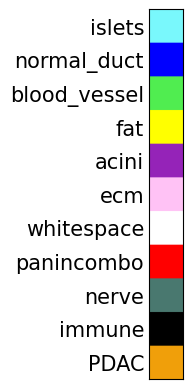

In [17]:
# 1 save model metadata
save_model_metadata(pthDL, pthim, WS, model_name, umpix, colormap, tile_size, classNames, ntrain, nvalidate)

In [ ]:
# Create tif images from /.ndpi / .svs


In [19]:
# 2 load and format annotations from each annotated image
[ctlist0, numann0] = load_annotation_data(pthDL, pth, pthim)

 
Importing annotation data...
Image 1 of 2: SG_013_0061
Checking parameters took 0.0 minutes and 0.0 seconds
 1. of 4. Importing annotation data from xml file
Loading annotation took 0.0 minutes and 0.887974739074707 seconds
 Creating file...
Import xml took 0.0 minutes and 0.9501867294311523 seconds
  Calculating TA image
Calculating tissue mask took 0.0 minutes and 9.493936777114868 seconds
 2. of 4. Interpolating annotated regions and saving mask image
Format white took 0.0 minutes and 21.594761848449707 seconds
Saving annotation mask took 1.0 minutes and 8.055063486099243 seconds
 4. of 4. Creating bounding box tiles of all annotations
Bounding boxes took 0.0 minutes and 11.373093605041504 seconds
 Finished image in 96 seconds.
Image 2 of 2: SG_014_0016
Checking parameters took 0.0 minutes and 0.0019190311431884766 seconds
 1. of 4. Importing annotation data from xml file
Loading annotation took 0.0 minutes and 1.289759874343872 seconds
 Creating file...
Import xml took 0.0 minute

In [ ]:
# 3 Make training & validation tiles for model training
create_training_tiles(pthDL, numann0, ctlist0)


Calculating total number of pixels in the training dataset...
 There are 20490300.0 pixels of islets, 18% of the most common class.
 There are 7288100.0 pixels of normal duct, 6% of the most common class.
 There are 17915900.0 pixels of blood vessel, 16% of the most common class.
 There are 28426000.0 pixels of fat, 26% of the most common class.
 There are 20212900.0 pixels of acini, 18% of the most common class.
 There are 107929600.0 pixels of ecm. This is the most common class.
 There are 84681200.0 pixels of whitespace, 78% of the most common class.
 There are 67231200.0 pixels of panincombo, 62% of the most common class.
 There are 11028200.0 pixels of nerve, 10% of the most common class.
 There are 31696900.0 pixels of immune, 29% of the most common class.
 There are 11098600.0 pixels of PDAC, 10% of the most common class.

Building training tiles...
Starting time for the while loop
Saving big tiles
  1 of 15 training images completed in 11 minutes
  Used 1666.7% counts and 100.

In [ ]:
# 4 Train model
train_segmentation_model(pthDL)

In [4]:
# 5 Test model
pthtest = r'C:\Users\Valentina\OneDrive - Johns Hopkins\Desktop\python model 2\testing images'
pthtestim = os.path.join(pthtest, '5x')
test_segmentation_model(pthDL, pthtest, pthtestim)

Testing segmentation model......
 
Importing annotation data...
Image 1 of 2: SG_013_0013
 1. of 4. Importing annotation data from xml file
 Creating file...


FileNotFoundError: No such file: 'C:\Users\Valentina\OneDrive - Johns Hopkins\Desktop\python model 2\testing images\5x\SG_013_0013.jp2'

   
  Starting classification of image 1 of 2: SG_013_0061.png
   Tile: 1 of 247 at (0, 0), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
   Tile: 2 of 247 at (0, 824), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 3 of 247 at (0, 1648), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 4 of 247 at (0, 2472), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 5 of 247 at (0, 3296), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 6 of 247 at (0, 4120), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 7 of 247 at (0, 4944), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 8 of 247 at (0, 5768), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 9 of 247 at (0, 6592), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 10 of 247 at (0, 7416), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 11 of 247 at (0, 8240), size: (

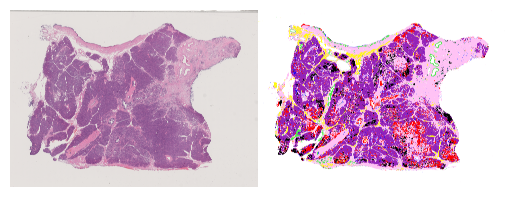

  Starting classification of image 2 of 2: SG_014_0016.png
   Tile: 1 of 300 at (0, 0), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 2 of 300 at (0, 824), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 3 of 300 at (0, 1648), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 4 of 300 at (0, 2472), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 5 of 300 at (0, 3296), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 6 of 300 at (0, 4120), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 7 of 300 at (0, 4944), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 8 of 300 at (0, 5768), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 9 of 300 at (0, 6592), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 10 of 300 at (0, 7416), size: (1024, 1024, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
   Tile: 11 of 300 at (0, 8240), size: (1024

'C:\\Users\\Valentina\\OneDrive - Johns Hopkins\\Desktop\\test png\\PNG\\classification_04_19_2024'

In [3]:
# 6 Classify images with pretrained model
pthim = r'C:\Users\Valentina\OneDrive - Johns Hopkins\Desktop\test png\PNG'
classify_images(pthim,pthDL)